In [3]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from utils import *
import scipy.stats
import seaborn as sns
from ipywidgets import interact, interactive, FloatProgress, IntProgress

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
fx_1minute_bar_catalog()

defaultdict(list,
            {'EURGBP': ['2015', '2014', '2013', '2016', '2012'],
             'EURJPY': ['2012', '2015', '2013', '2016', '2014'],
             'EURUSD': ['2012', '201612', '2013', '2014', '2016', '2015'],
             'GBPCHF': ['2015', '2014', '2016'],
             'GBPJPY': ['2016', '2013', '2015', '2014', '2012'],
             'GBPUSD': ['2013', '2015', '2012', '2014', '2016'],
             'USDJPY': ['2013', '2016', '2014', '2015', '2012'],
             'XAGUSD': ['2013', '2015', '2016', '2012', '2014'],
             'XAUGBP': ['2012', '2016', '2015', '2014', '2013'],
             'XAUUSD': ['2012', '2015', '2014', '2013', '2016']})

In [50]:
ds = load_1minute_fx_bars('USDJPY', 2012)[['open','high','low','close']]
len(ds)

365686

In [56]:
RETURN_PERIOD = 1
ANN_FACTOR_1MINUTE_BARS = np.sqrt(252 * 24 * 60 / RETURN_PERIOD)
TS_SECS = 60 # number of seconds in a regular timestep. 60 for 1x 1-minute bar

DAY = 24*60
DAY

1440

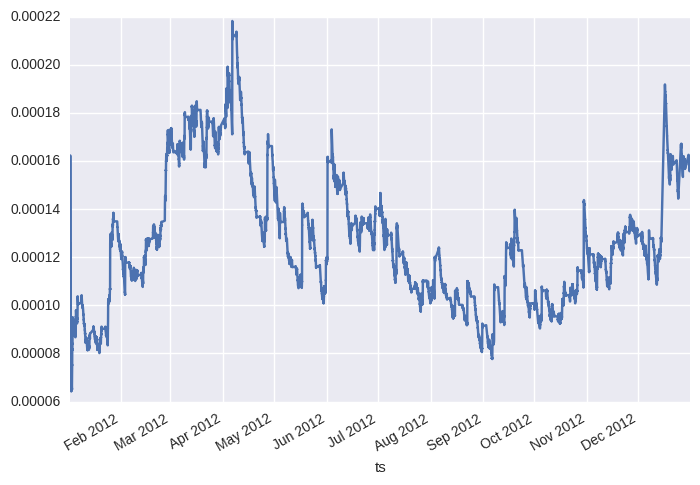

In [77]:
lret = logreturn(ds['close'],ds['close'].shift(1))
vol = lret.ewm(3*DAY).std()

vol.plot()


In [85]:
ser_open =  (ds['open']/ds['close']-1)/vol 
ser_high = ((ds['high']/ds['close']-1)/vol - 0.5)
ser_low =  ((ds['low']/ds['close']-1)/vol + 0.5)
ser_lret=  (lret/vol)

print "open", ser_open.describe()
print "high",ser_high.describe()
print "low", ser_low.describe()
print "lret", ser_lret.describe()

open count    365684.000000
mean         -0.004300
std           0.962687
min         -28.958733
25%          -0.381508
50%           0.000000
75%           0.369720
max          33.619577
dtype: float64
high count    365684.000000
mean          0.014127
std           0.698180
min          -0.500000
25%          -0.403358
50%          -0.208293
75%           0.202055
max          53.638116
dtype: float64
low count    365684.000000
mean         -0.021313
std           0.697649
min         -28.458733
25%          -0.214859
50%           0.203451
75%           0.401579
max           0.500000
dtype: float64
lret count    365684.000000
mean          0.002734
std           1.002456
min         -35.262359
25%          -0.401442
50%           0.000000
75%           0.409496
max          49.008739
Name: close, dtype: float64


In [87]:
RETURN_PERIOD = 1
ANN_FACTOR_1MINUTE_BARS = np.sqrt(252 * 24 * 60 / RETURN_PERIOD)
TS_SECS = 60 # number of seconds in a regular timestep. 60 for 1x 1-minute bar
DAY = 24*60

def load_data(sym, date):
    
    data = {}
    ds = load_1minute_fx_bars(sym, date)[['open','high','low','close']]
    lret = logreturn(ds['close'],ds['close'].shift(RETURN_PERIOD))
    vol = lret.ewm(3*DAY).std()                                         
                                         
    ser_open =  (ds['open']/ds['close']-1)/vol 
    ser_high = ((ds['high']/ds['close']-1)/vol - 0.5)
    ser_low =  ((ds['low']/ds['close']-1)/vol + 0.5)
    ser_lret=  (lret/vol)                                         
        
    df= pd.DataFrame()
    df['lret'] = ser_lret
    df['open'] = ser_open
    df['high'] = ser_high
    df['low'] = ser_low                                    
    
    df = df.fillna(0)
    # put add timestamp into dataframe, and compute time since last sample
    df['ts'] = df.index
    df['time_step'] = ((df['ts']- df['ts'].shift(RETURN_PERIOD)) * 1e-9).astype(int)
    
    return df

In [136]:
sym='EURGBP'
date = 2012

In [137]:
df = load_data(sym, date)

In [138]:
print df.head(5)

                         lret      open      high       low  \
ts                                                            
2012-01-02 02:00:00  0.000000  0.000000  0.000000  0.000000   
2012-01-02 02:01:00  0.000000  0.000000  0.000000  0.000000   
2012-01-02 02:02:00  9.904128 -4.244448  0.914816 -3.744448   
2012-01-02 02:03:00 -0.829329  0.552906  0.605811  0.500000   
2012-01-02 02:04:00  1.326865 -2.211322 -0.500000 -2.006165   

                                     ts            time_step  
ts                                                            
2012-01-02 02:00:00 2012-01-02 02:00:00 -9223372036854775808  
2012-01-02 02:01:00 2012-01-02 02:01:00                   60  
2012-01-02 02:02:00 2012-01-02 02:02:00                   60  
2012-01-02 02:03:00 2012-01-02 02:03:00                   60  
2012-01-02 02:04:00 2012-01-02 02:04:00                   60  


In [139]:
# 1/2 hour lookback
sequence_length = 30

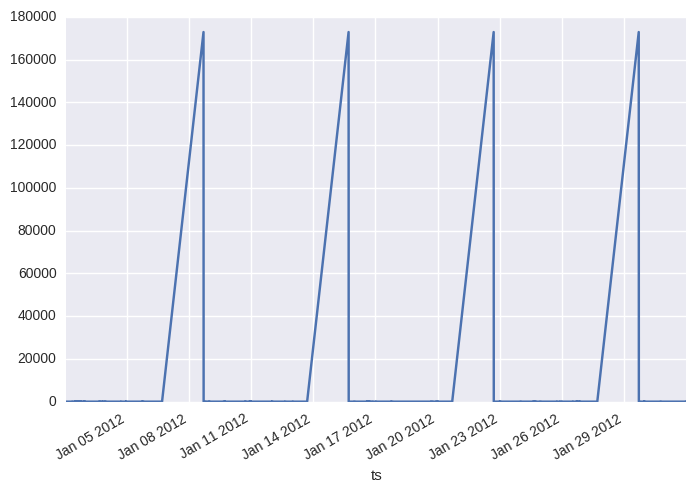

In [147]:
df['time_step']['2012-01'][1:].plot()

In [ ]:
# average run length
max_samples = len(df) - sequence_length
progress = IntProgress(min=0, max=max_samples)
display(progress)
i = 0
rl = 0
results = []
while i < max_samples:
    if df['time_step'][i] == TS_SECS:
        rl += 1
    else:
        results.append(rl)
        while df['time_step'][i] != TS_SECS:
            i+=1
        rl = 0
    i +=1
    if i%1000 == 0:
        progress.value = i

run_length = pd.Series(results)

In [ ]:
display(run_length.describe())
run_length.hist(bins=50,range=(0,10))


In [141]:
sequence_length

30

In [142]:
df.head()

,lret,open,high,low,ts,time_step
ts,,,,,,
2012-01-02 02:00:00,0.000000,0.000000,0.000000,0.000000,2012-01-02 02:00:00,-9223372036854775808
2012-01-02 02:01:00,0.000000,0.000000,0.000000,0.000000,2012-01-02 02:01:00,60
2012-01-02 02:02:00,9.904128,-4.244448,0.914816,-3.744448,2012-01-02 02:02:00,60
2012-01-02 02:03:00,-0.829329,0.552906,0.605811,0.500000,2012-01-02 02:03:00,60
2012-01-02 02:04:00,1.326865,-2.211322,-0.500000,-2.006165,2012-01-02 02:04:00,60


In [143]:
%%time

# construct samples
max_samples = len(df) - sequence_length
#max_samples = 5000

n_features = 4 
features = ['lret', 'open','high','low']

progress = IntProgress(min=0, max=max_samples)
display(progress)

sequences = np.zeros((max_samples, sequence_length, n_features))
seq_idx = 0                     

i = 0
while not (df['time_step'][i:i+sequence_length] == TS_SECS).all():
    i += 1
print "skipped",i
while i < max_samples:   
    steps = df['time_step'][i:i+sequence_length]    
    # only include sequences where all samples have the same step size
    if (steps == TS_SECS).all():
        seq = df[features][i: i + sequence_length]
        sequences[seq_idx] = seq
        seq_idx +=1

    i += 1
    if i%1000 == 0:
        progress.value = i

print seq_idx, sequences.shape
sequences = sequences[:seq_idx,:,:]
print sequences.shape

skipped 1
305055 (368623, 30, 4)
(305055, 30, 4)
CPU times: user 12min 54s, sys: 836 ms, total: 12min 54s
Wall time: 12min 54s


In [144]:
fname = "ohlret_sequences_{l}_{s}_{d}.h5".format(s=sym, d=date, l=sequence_length)
print fname

ohlret_sequences_30_EURGBP_2012.h5


In [145]:
import h5py
with h5py.File(fname, 'w') as f:
    f['sequences'] = sequences

In [146]:
with h5py.File(fname, 'r') as f:
    sequences = f['sequences'][...]

In [122]:
sequences.shape

(353743, 30, 4)


# tests 
Target = 
- sum of sequence. can it learn to add them up..???
- mean of first half of sequence
- mean of first half of sequence minus mean of second half of sequence
( can do this on random data..)